In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [265]:
df = pd.read_csv('../data/data.csv', encoding='latin1')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Minimo de quantity e UnitPrice e max também estão estranhos, outliers? os minimos serao separados posteriormente, maximo precisamos verificar, precisamos verificar também se tem 0s no Quantity e unitprice, mas apenas depois de retirar os cancelamentos.

In [266]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [ ]:
df.sample(7, random_state=1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
94801,C544414,22960,JAM MAKING SET WITH JARS,-2,2/18/2011 14:54,3.75,13408.0,United Kingdom
210111,555276,48111,DOORMAT 3 SMILEY CATS,1,6/1/2011 17:28,15.79,NaN,United Kingdom
455946,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,11/10/2011 14:29,0.55,13319.0,United Kingdom
403542,571636,20674,GREEN POLKADOT BOWL,16,10/18/2011 11:41,1.25,13509.0,United Kingdom
471951,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,11/16/2011 11:03,1.65,12720.0,Germany
380570,569823,23298,SPOTTY BUNTING,1,10/6/2011 12:15,4.95,16895.0,United Kingdom
384867,570185,21090,WET/MOULDY,-192,10/7/2011 14:56,0.00,NaN,United Kingdom
447064,574943,17091J,VANILLA INCENSE IN TIN,36,11/8/2011 7:52,0.38,13026.0,United Kingdom


- Percebi que tem registros cancelados C544414, vamos separar estes registros , guardar numa variavel e excluir do df original pois nao agrega na analise dos customers, mas serve pra analisar os cancelamentos . Percebi tambem que no indice 384867 Quantity esta negativo mas nao foi registrado cancelamento, entao verificarei se isso ocorre em mais registros


In [268]:
df_cancelamentos = df[df['InvoiceNo'].str.startswith('C')]
df_cancelamentos.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


Percebemos tambem que temos registros especiais no StockCode, Agora vamos deixar apenaas os registros que nao tem nao tem a letra C no comeco :

In [269]:
df = df[~df['InvoiceNo'].str.startswith('C')]

Verificando os registros especiais :

In [270]:
reg_especiais = df['StockCode'].str.match(r'^[A-Za-z]')

df[reg_especiais]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.00,12583.0,France
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.00,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,12/1/2010 13:04,18.00,12662.0,Germany
1423,536540,C2,CARRIAGE,1,12/1/2010 14:05,50.00,14911.0,EIRE
1814,536544,DOT,DOTCOM POSTAGE,1,12/1/2010 14:32,569.77,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,12/9/2011 10:13,18.00,12518.0,Germany
541540,581498,DOT,DOTCOM POSTAGE,1,12/9/2011 10:26,1714.17,NaN,United Kingdom
541730,581570,POST,POSTAGE,1,12/9/2011 11:59,18.00,12662.0,Germany
541767,581574,POST,POSTAGE,2,12/9/2011 12:09,18.00,12526.0,Germany


retirando - os do dataframe :

In [271]:
df = df[df['StockCode'].str.match(r'^\d')]

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [272]:
print(df.info())

print('\n Dados faltantes: \n\n',df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 530210 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530210 non-null  object 
 1   StockCode    530210 non-null  object 
 2   Description  528771 non-null  object 
 3   Quantity     530210 non-null  int64  
 4   InvoiceDate  530210 non-null  object 
 5   UnitPrice    530210 non-null  float64
 6   CustomerID   396370 non-null  float64
 7   Country      530210 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.4+ MB
None

 Dados faltantes: 

 InvoiceNo           0
StockCode           0
Description      1439
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133840
Country             0
dtype: int64


In [273]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df_missing = df[df['CustomerID'].isnull() | df['Description'].isnull()]
df_missing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541535,581498,85049e,SCANDINAVIAN REDS RIBBONS,4,2011-12-09 10:26:00,3.29,NaN,United Kingdom
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom


In [274]:
missing_before = df['CustomerID'].isna().sum()
print(f'CustomerID faltantes ANTES: {missing_before}')


match_cols = [
    'InvoiceDate',
    'StockCode',
    'Quantity',
    'UnitPrice',
    'Country'
]

# =========================
# 4. Criar tabela de referência
# Apenas padrões que levam a UM único CustomerID
# =========================
reference_valid = (
    df.dropna(subset=['CustomerID'])
      .groupby(match_cols)['CustomerID']
      .nunique()
      .reset_index()
)

reference_valid = reference_valid[reference_valid['CustomerID'] == 1]

reference = (
    df.dropna(subset=['CustomerID'])
      .merge(reference_valid[match_cols], on=match_cols, how='inner')
      [match_cols + ['CustomerID']]
      .drop_duplicates()
)

# =========================
# 5. Merge para tentar preencher
# =========================
df = df.merge(
    reference,
    on=match_cols,
    how='left',
    suffixes=('', '_filled')
)

df['CustomerID'] = df['CustomerID'].fillna(df['CustomerID_filled'])
df.drop(columns='CustomerID_filled', inplace=True)

# =========================
# 6. Resultado final
# =========================
missing_after = df['CustomerID'].isna().sum()
print(f'CustomerID faltantes DEPOIS: {missing_after}')
print(f'Recuperados: {missing_before - missing_after}')


CustomerID faltantes ANTES: 133840
CustomerID faltantes DEPOIS: 133840
Recuperados: 0


In [275]:
df = df.dropna(subset=['CustomerID', 'Description'])
df.shape

(396370, 8)

In [276]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Verificndo se ha registros onde quatidade e negtivo e portanto cancelado (ja dropamos O C)

In [277]:
df[df['Quantity'] <= 0 ]  

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [278]:
df.shape

(396370, 8)

Tudo OK

In [279]:
df[df['UnitPrice'] <= 0 ].shape

(33, 8)

33 registros onde UnitPrice = 0, precisamos apagar

In [280]:
df = df[df['UnitPrice'] > 0]
df.shape

(396337, 8)

In [281]:
df.duplicated().sum()
df_duplicates = df[df.duplicated(keep=False)]
df_duplicates

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
474,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
478,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
483,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
506,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
510,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
529982,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
529996,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
529999,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
530006,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


Exemplo real (sua imagem):

InvoiceNo 536409 tem:

SCOTTIE DOG HOT WATER BOTTLE

HAND WARMER SCOTTY DOG DESIGN

UNION JACK FLAG LUGGAGE TAG

SET 2 TEA TOWELS LOVE LONDON

🧠 Isso é um pedido com vários itens, não duplicata.             

Estes registros acima são registros onde há duplicados, ou seja, estão iguais a outros registros, e portanto devem ser excluídos.

In [282]:
df = df.drop_duplicates()
df.shape

(391150, 8)

Feature engineering :

In [283]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
530205,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
530206,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
530207,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
530208,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [284]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,391150.0,13.1453,1.0,2.0,6.0,12.0,80995.0,180.807831
InvoiceDate,391150,2011-07-10 19:37:34.766713600,2010-12-01 08:26:00,2011-04-07 11:16:00,2011-07-31 12:05:00,2011-10-20 12:57:00,2011-12-09 12:50:00,NaN
UnitPrice,391150.0,2.874372,0.04,1.25,1.95,3.75,649.5,4.284738
CustomerID,391150.0,15295.171456,12346.0,13969.0,15159.0,16794.0,18287.0,1710.339033
Revenue,391150.0,22.337281,0.06,4.95,11.9,19.8,168469.6,310.932442


### EDA do dataframe :

### RFM

In [285]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df
    .groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',                                     # Frequency
        'Revenue': 'sum'                                            # Monetary
    })
    .reset_index()
)

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head(5)



,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


In [286]:
customer_id = 12346

ultima_compra = df.loc[df['CustomerID'] == customer_id, 'InvoiceDate'].max()
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

(snapshot_date - ultima_compra).days


326

In [287]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4334.0,15299.251731,1721.994109,12346.00,13812.25,15297.500,16778.7500,18287.00
Recency,4334.0,92.703046,100.177047,1.00,18.00,51.000,143.0000,374.00
Frequency,4334.0,4.245962,7.634989,1.00,1.00,2.000,5.0000,206.00
Monetary,4334.0,2015.973152,8903.673825,3.75,304.24,662.565,1631.6225,279138.02


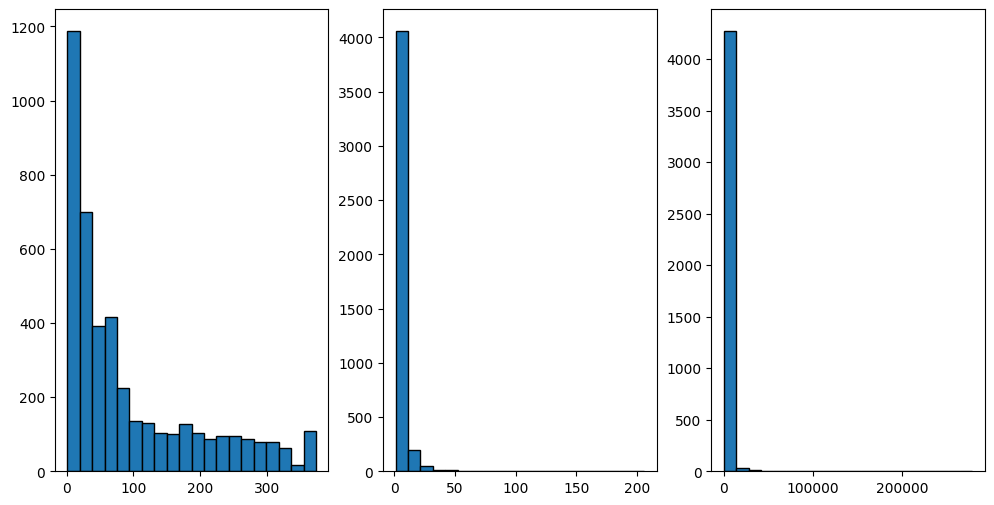

In [288]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].hist(rfm['Recency'], bins=20, edgecolor='black')
ax[1].hist(rfm['Frequency'], bins=20, edgecolor='black')
ax[2].hist(rfm['Monetary'], bins=20, edgecolor='black')

plt.show()

In [289]:
rfm['Monetary'].describe(percentiles=[.5, .75, .9, .95, .99])


count      4334.000000
mean       2015.973152
std        8903.673825
min           3.750000
50%         662.565000
75%        1631.622500
90%        3560.080000
95%        5735.215500
99%       18715.313000
max      279138.020000
Name: Monetary, dtype: float64

In [290]:
rfm['Frequency'].describe(percentiles=[.5, .75, .9, .95, .99])


count    4334.000000
mean        4.245962
std         7.634989
min         1.000000
50%         2.000000
75%         5.000000
90%         9.000000
95%        13.000000
99%        30.000000
max       206.000000
Name: Frequency, dtype: float64

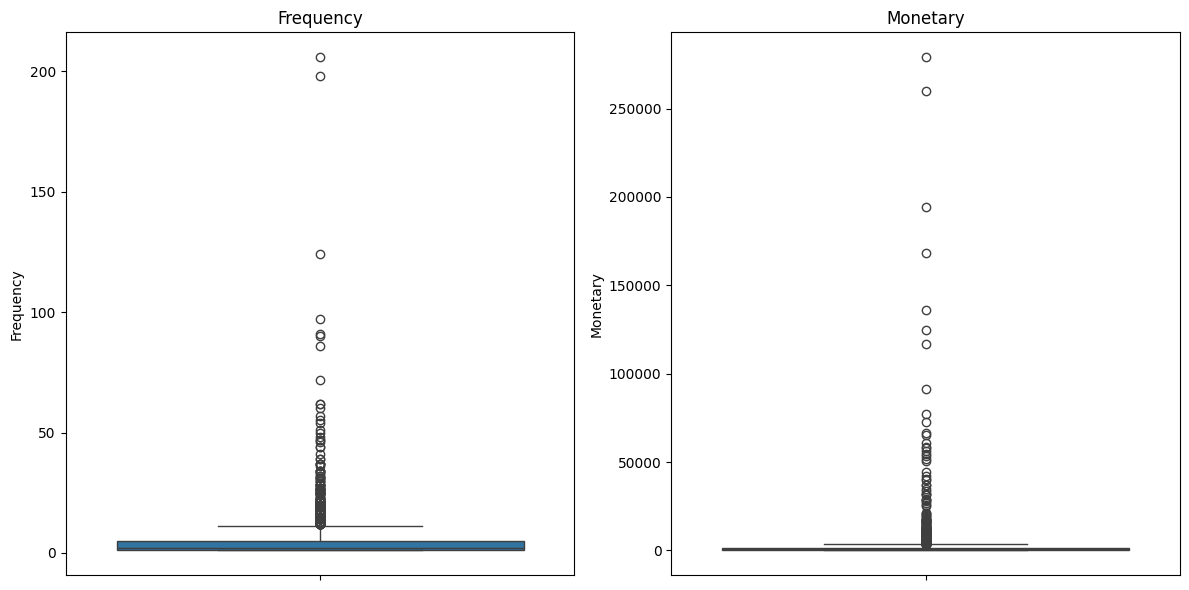

In [291]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y='Frequency', data=rfm, ax=axes[0])
sns.boxplot(y='Monetary', data=rfm, ax=axes[1])

axes[0].set_title('Frequency')
axes[1].set_title('Monetary')

plt.tight_layout()
plt.show()


In [292]:
def winsorize(series, lower=0.01, upper=0.99):
    return series.clip(
        lower=series.quantile(lower),
        upper=series.quantile(upper)
    )

rfm_w = rfm.copy()

for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_w[col] = winsorize(rfm[col])


rfm_w.describe().T


,count,mean,std,min,25%,50%,75%,max
CustomerID,4334.0,15299.251731,1721.994109,12346.0,13812.25,15297.500,16778.7500,18287.000
Recency,4334.0,92.667974,100.079554,1.0,18.00,51.000,143.0000,369.000
Frequency,4334.0,3.986617,4.846435,1.0,1.00,2.000,5.0000,30.000
Monetary,4334.0,1556.961789,2680.217048,52.2,304.24,662.565,1631.6225,18715.313


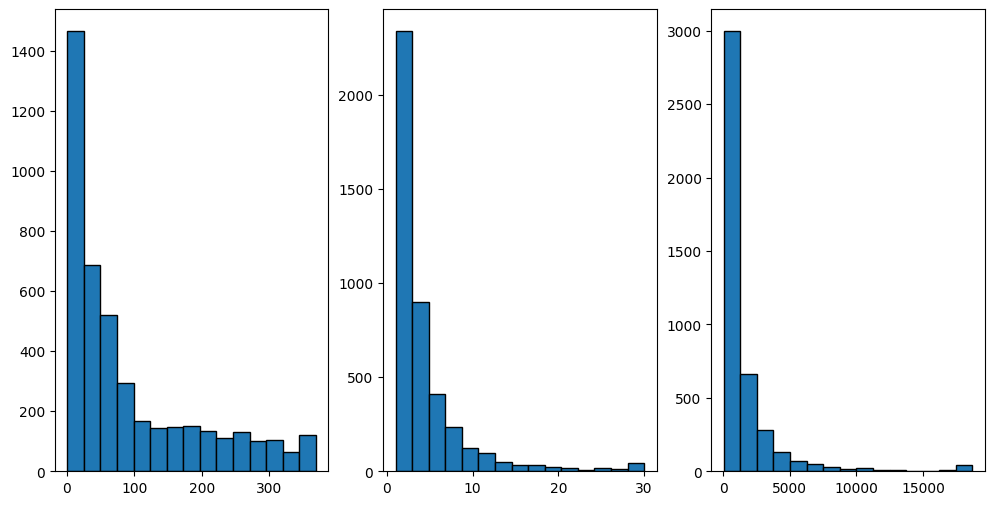

In [293]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].hist(rfm_w['Recency'], bins=15, edgecolor='black')
ax[1].hist(rfm_w['Frequency'], bins=15, edgecolor='black')
ax[2].hist(rfm_w['Monetary'], bins=15, edgecolor='black')

plt.show()

In [294]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


In [295]:
top5_products = df['Description'].value_counts().head(5).index
top5_countries = df['Country'].value_counts().head(5).index
top5_products_rev_df = (
    df.groupby('Description', as_index=False)['Revenue']
      .sum()
      .sort_values('Revenue', ascending=False)
      .head(5)
)



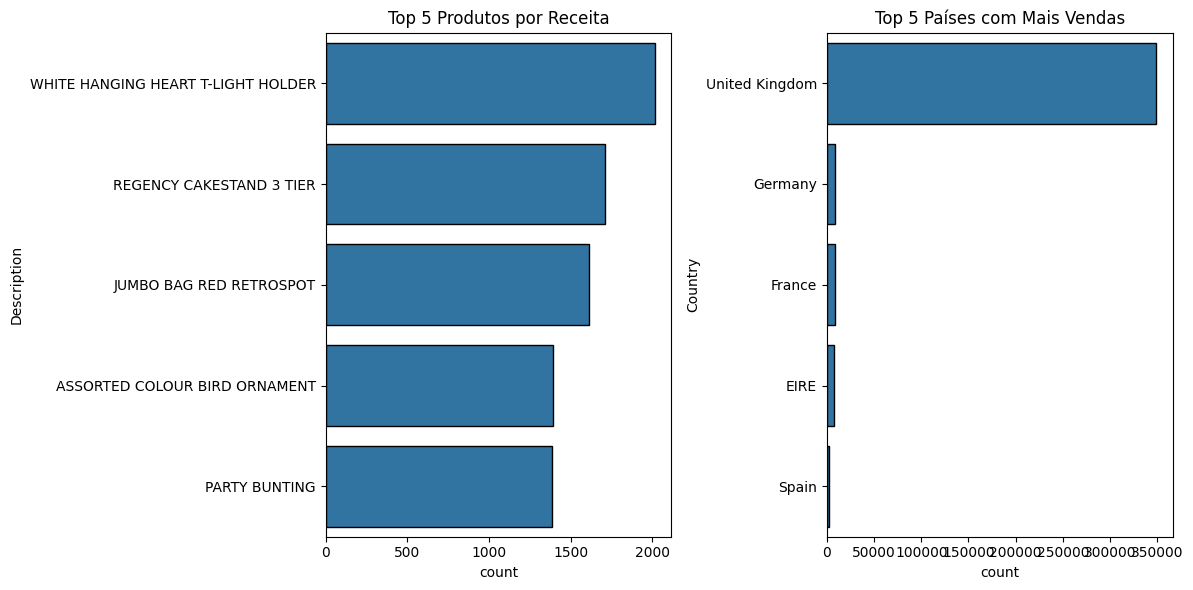

In [296]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(
    y='Description',
    data=df[df['Description'].isin(top5_products)],
    order=top5_products,
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title('Top 5 Produtos Mais Vendidos')

sns.countplot(
    y='Country',
    data=df[df['Country'].isin(top5_countries)],
    order=top5_countries,
    edgecolor='black',
    ax=axes[1]
)

axes[0].set_title('Top 5 Produtos por Receita')
axes[1].set_title('Top 5 Países com Mais Vendas')



plt.tight_layout()
plt.show()


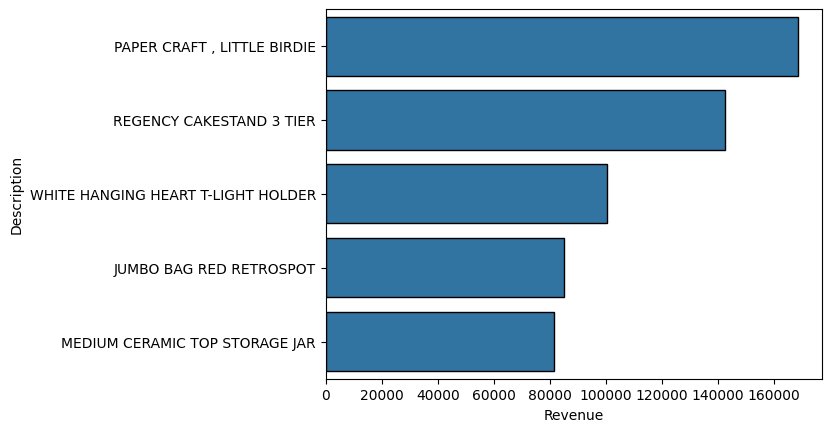

In [297]:
sns.barplot(
    y='Description',
    x='Revenue',
    data=top5_products_rev_df,
    edgecolor='black',
)

plt.show()

In [298]:
df_daily = (
    df.groupby(df['InvoiceDate'].dt.date)
      .agg({
          'Quantity': 'sum',
          'Revenue': 'sum'
      })
      .reset_index()
)

df_daily.rename(columns={'InvoiceDate': 'Date'}, inplace=True)


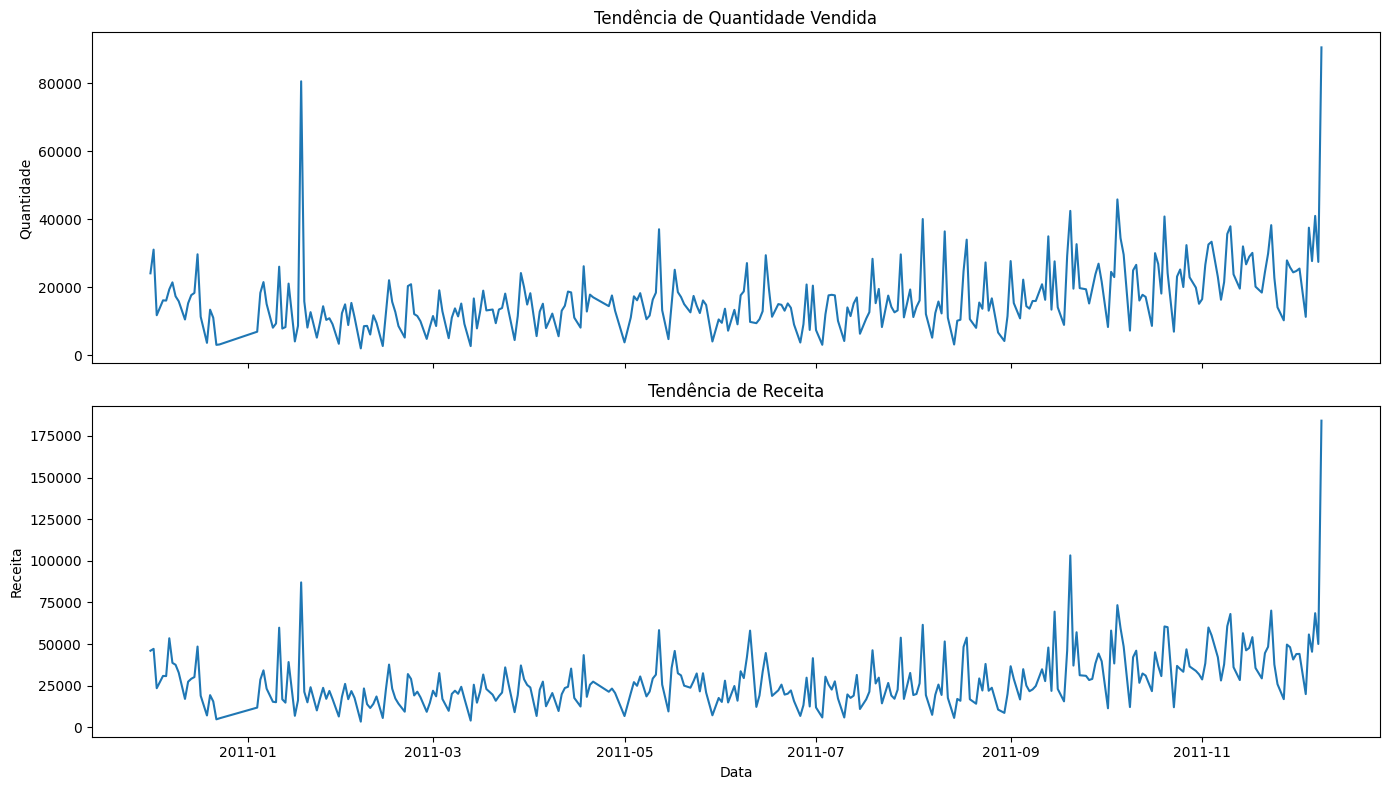

In [299]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(df_daily['Date'], df_daily['Quantity'])
axes[0].set_title('Tendência de Quantidade Vendida')
axes[0].set_ylabel('Quantidade')

axes[1].plot(df_daily['Date'], df_daily['Revenue'])
axes[1].set_title('Tendência de Receita')
axes[1].set_ylabel('Receita')
axes[1].set_xlabel('Data')

plt.tight_layout()
plt.show()


In [300]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


In [301]:
rfm.head(1)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.6


In [302]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm[['Recency', 'Frequency', 'Monetary']]
)

rfm_scaled = pd.DataFrame(
    rfm_scaled,
    columns=['Recency', 'Frequency', 'Monetary'],
    index=rfm.index
)


In [303]:
pca = PCA()
pca.fit(rfm_scaled)

explained_variance = pca.explained_variance_ratio_

explained_variance


array([0.55323304, 0.30251578, 0.14425119])

In [304]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm_pca = pd.DataFrame(
    rfm_pca,
    columns=['PC1', 'PC2'],
    index=rfm.index
)


In [305]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


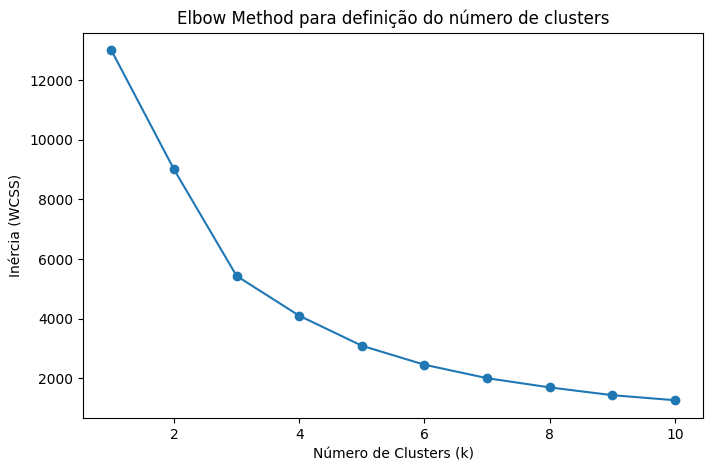

In [306]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.title('Elbow Method para definição do número de clusters')
plt.show()


In [307]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)


In [308]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346.0,326,1,77183.60,1
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1437.24,0
3,12349.0,19,1,1457.55,0
4,12350.0,310,1,294.40,1


In [309]:
rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
cluster,,,
0,40.990701,4.826100,1970.191262
1,246.287934,1.572212,623.486188
2,7.142857,79.500000,121378.338571


In [310]:
rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].median()


,Recency,Frequency,Monetary
cluster,,,
0,30.0,3.0,912.30
1,241.0,1.0,309.46
2,2.5,61.0,103811.23


In [311]:
rfm['cluster'].value_counts(normalize=True) * 100


cluster
0    74.434702
1    25.242270
2     0.323027
Name: proportion, dtype: float64

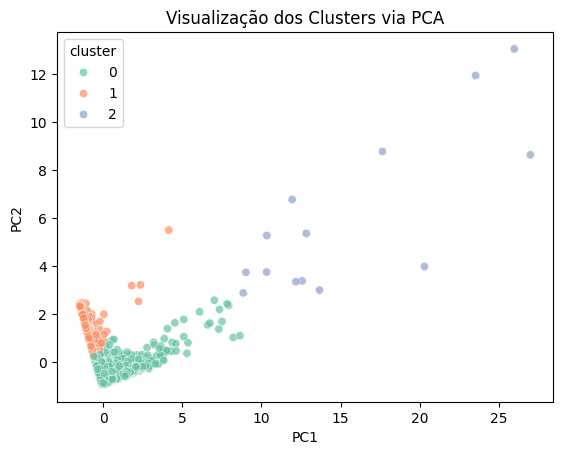

In [312]:
rfm_pca['cluster'] = rfm['cluster']

sns.scatterplot(
    data=rfm_pca,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2',
    alpha=0.7
)
plt.title('Visualização dos Clusters via PCA')
plt.show()



In [313]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm['cluster_db'] = dbscan.fit_predict(rfm_scaled)



In [314]:
rfm['cluster_db'].value_counts()


cluster_db
 0    4292
-1      42
Name: count, dtype: int64

In [ ]:
rfm_pca_db = rfm_pca.copy()
rfm_pca_db['cluster_db'] = rfm['cluster_db']

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_pca_db,
    x='PC1',
    y='PC2',
    hue='cluster_db',
    palette='tab10',
    alpha=0.7
)
plt.title('DBSCAN — Detecção de Outliers (-1)')
plt.show()


In [ ]:
rfm_clean = rfm[rfm['cluster_db'] != -1].copy()
rfm_scaled_clean = rfm_scaled[rfm['cluster_db'] != -1]


“Aplicamos DBSCAN como método complementar para identificação de clientes atípicos. Os pontos classificados como ruído (-1) foram removidos antes do treinamento final do KMeans, resultando em clusters mais estáveis e representativos do comportamento predominante da base.”

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init=20)
rfm_clean['cluster'] = kmeans.fit_predict(rfm_scaled_clean)


In [ ]:
rfm_pca_clean = pca.fit_transform(rfm_scaled_clean)
rfm_pca_clean = pd.DataFrame(
    rfm_pca_clean,
    columns=['PC1', 'PC2'],
    index=rfm_clean.index
)

rfm_pca_clean['cluster'] = rfm_clean['cluster']


In [ ]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=rfm_pca_clean,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2',
    alpha=0.7
)

plt.title('Visualização dos clusters finais via PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
rfm_cluster_summary = (
    rfm_clean
    .groupby('cluster')
    .agg(
        customers=('CustomerID', 'count'),
        recency_mean=('Recency', 'mean'),
        recency_median=('Recency', 'median'),
        frequency_mean=('Frequency', 'mean'),
        frequency_median=('Frequency', 'median'),
        monetary_mean=('Monetary', 'mean'),
        monetary_median=('Monetary', 'median')
    )
)

rfm_cluster_summary


In [ ]:
rfm_clean['cluster'].value_counts(normalize=True) * 100


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=rfm_clean, x='cluster', y='Recency', ax=axes[0])
sns.boxplot(data=rfm_clean, x='cluster', y='Frequency', ax=axes[1])
sns.boxplot(data=rfm_clean, x='cluster', y='Monetary', ax=axes[2])

axes[0].set_title('Recency por cluster')
axes[1].set_title('Frequency por cluster')
axes[2].set_title('Monetary por cluster')

plt.tight_layout()
plt.show()


In [ ]:
rfm_cluster_summary['R_rank'] = rfm_cluster_summary['recency_median'].rank(ascending=True)
rfm_cluster_summary['F_rank'] = rfm_cluster_summary['frequency_median'].rank(ascending=False)
rfm_cluster_summary['M_rank'] = rfm_cluster_summary['monetary_median'].rank(ascending=False)

rfm_cluster_summary.sort_values(
    by=['R_rank', 'F_rank', 'M_rank']
)
